<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/model/BERT_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [28]:
!pip3 install --quiet tensorflow
!pip3 install --quiet tensorflow_text

In [29]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import pairwise
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

In [30]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

# Data Setup

In [31]:
data=pd.read_csv('./Peterpan_emo3.csv')
data=data.dropna(how='any')
print(f'Dimensions: {data.shape}')
data

Dimensions: (1697, 4)


,Unnamed: 0,sentence,posNeg,posNeg3
0,0,Chapter 1 PETER BREAKS THROUGH,0.000000,1.0
1,1,"All children, except one, grow up. They soon k...",0.311111,2.0
2,2,Of course they lived at 14 [their house number...,0.279545,2.0
3,3,The way Mr. Darling won her was this: the many...,0.483333,2.0
4,4,Mr. Darling used to boast to Wendy that her mo...,0.148889,1.0
...,...,...,...,...
1692,1692,"“If only I could go with you,” Wendy sighed.",0.000000,1.0
1693,1693,"“You see you can't fly,” said Jane.",0.800000,2.0
1694,1694,Of course in the end Wendy let them fly away t...,0.183333,2.0
1695,1695,"As you look at Wendy, you may see her hair bec...",0.097396,1.0


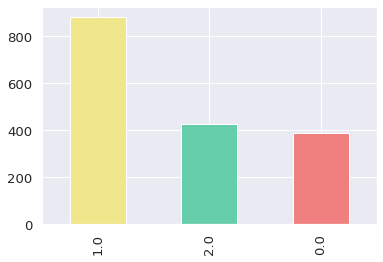

In [32]:
colors = ['khaki','mediumaquamarine','lightcoral']
data['posNeg3'].value_counts().plot(kind='bar',color=colors)


In [33]:
x_data = data['sentence']
y_data = data['posNeg3']
print('메일 본문의 개수: {}'.format(len(x_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 1697
레이블의 개수: 1697


# Bert Embedding

In [35]:
sentences=data['sentence'].tolist()
Y_data= data['posNeg3'].tolist()

In [36]:
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)
inputs = preprocess(sentences[:500])
outputs = bert(inputs)

In [18]:
print("Sentences:")
print(sentences)

print("\nBERT inputs:")
print(inputs)

#문장단위 임베딩
print("\nPooled embeddings:")
print(outputs["pooled_output"])

#단어 토큰단위 임베딩
print("\nPer token embeddings:")
print(outputs["sequence_output"])

Sentences:
['Chapter 1 PETER BREAKS THROUGH', "All children, except one, grow up. They soon know that they will grow up, and the way Wendy knew was this. One day when she was two years old she was playing in a garden, and she plucked another flower and ran with it to her mother. I suppose she must have looked rather delightful, for Mrs. Darling put her hand to her heart and cried, “Oh, why can't you remain like this for ever!” This was all that passed between them on the subject, but henceforth Wendy knew that she must grow up. You always know after you are two. Two is the beginning of the end.", 'Of course they lived at 14 [their house number on their street], and until Wendy came her mother was the chief one. She was a lovely lady, with a romantic mind and such a sweet mocking mouth. Her romantic mind was like the tiny boxes, one within the other, that come from the puzzling East, however many you discover there is always one more; and her sweet mocking mouth had one kiss on it that 

In [14]:
#simularity Visualization

def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = pairwise.cosine_similarity(features)
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, cmap="Blues", cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")
#plot_similarity(outputs["pooled_output"], sentences)
#훈련한 모든 문장도 함께 시각화 되기에 
#가독성의 어려움이 있어 주석처리함

In [37]:
len(outputs["pooled_output"])

500

In [38]:
n_of_train = int(len(outputs["pooled_output"]) * 0.8)
n_of_test = int(len(outputs["pooled_output"])- n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

훈련 데이터의 개수 : 400
테스트 데이터의 개수: 100


In [39]:
X_data = outputs["pooled_output"]
Y_data=Y_data[:500]

In [40]:
data = pad_sequences(X_data)
print("훈련 데이터의 크기(shape): ", data.shape)
X_test = X_data[n_of_train:] 
Y_test = np.array(Y_data[n_of_train:])
X_train = X_data[:n_of_train]
Y_train = np.array(Y_data[:n_of_train])

훈련 데이터의 크기(shape):  (500, 768)


# Tokenize

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_data) #X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(x_data) # 단어를 숫자값, 인덱스로 변환하여 저장

In [ ]:
sequences[:5]

[[345, 1717, 23, 1718, 129],
 [33,
  76,
  319,
  40,
  611,
  46,
  13,
  216,
  77,
  11,
  13,
  83,
  611,
  46,
  3,
  1,
  80,
  29,
  94,
  6,
  39,
  40,
  222,
  43,
  12,
  6,
  154,
  882,
  244,
  12,
  6,
  479,
  10,
  7,
  2609,
  3,
  12,
  1719,
  200,
  1295,
  3,
  346,
  27,
  9,
  4,
  16,
  81,
  31,
  522,
  12,
  107,
  32,
  193,
  161,
  1057,
  19,
  90,
  65,
  165,
  16,
  113,
  4,
  16,
  331,
  3,
  54,
  157,
  292,
  237,
  18,
  1058,
  75,
  39,
  19,
  131,
  2,
  39,
  6,
  33,
  11,
  404,
  426,
  30,
  22,
  1,
  1059,
  17,
  1720,
  29,
  94,
  11,
  12,
  107,
  611,
  46,
  18,
  120,
  77,
  122,
  18,
  41,
  154,
  154,
  25,
  1,
  679,
  8,
  1,
  320],
 [8,
  95,
  13,
  612,
  28,
  1296,
  37,
  135,
  1297,
  22,
  37,
  613,
  3,
  293,
  29,
  89,
  16,
  81,
  6,
  1,
  1060,
  40,
  12,
  6,
  7,
  321,
  210,
  27,
  7,
  1061,
  322,
  3,
  108,
  7,
  405,
  1062,
  223,
  16,
  1061,
  322,
  6,
  75,
  1,
  883,
  2610,
  4

In [ ]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(word_to_index)

{'the': 1, '”': 2, 'and': 3, 'to': 4, 'he': 5, 'was': 6, 'a': 7, 'of': 8, 'it': 9, 'in': 10, 'that': 11, 'she': 12, 'they': 13, 'had': 14, 'his': 15, 'her': 16, 'but': 17, 'you': 18, 'for': 19, 'not': 20, 'said': 21, 'on': 22, 'peter': 23, 'him': 24, 'is': 25, 'as': 26, 'with': 27, 'at': 28, 'wendy': 29, 'them': 30, 'i': 31, 'have': 32, 'all': 33, 'were': 34, 'be': 35, 'so': 36, 'their': 37, 'would': 38, 'this': 39, 'one': 40, 'are': 41, 'there': 42, 'when': 43, 'by': 44, 'out': 45, 'up': 46, 'no': 47, '“i': 48, 'now': 49, 'hook': 50, 'we': 51, 'could': 52, 'if': 53, 'cried': 54, 'been': 55, 'then': 56, 'from': 57, 'who': 58, 'what': 59, 'time': 60, 'did': 61, 'which': 62, 'john': 63, 'do': 64, 'darling': 65, 'about': 66, 'me': 67, 'see': 68, 'little': 69, 'into': 70, 'boys': 71, 'an': 72, 'michael': 73, 'again': 74, 'like': 75, 'children': 76, 'know': 77, 'only': 78, 'night': 79, 'way': 80, 'mother': 81, 'first': 82, 'will': 83, 'never': 84, 'more': 85, 'thought': 86, 'just': 87, 'go'

In [ ]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 2658
단어 집합(vocabulary)에서 희귀 단어의 비율: 50.47474363843525
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.426372414919462


In [ ]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

훈련 데이터의 개수 : 1357
테스트 데이터의 개수: 340


메일의 최대 길이 : 362
메일의 평균 길이 : 28.864467


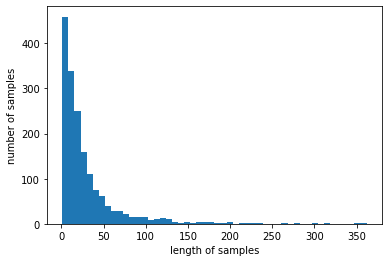

In [ ]:
X_data = sequences
print('문장의 최대 길이 : %d' % max(len(l) for l in X_data))
print('문장의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_len = 362
# 전체 데이터셋의 길이는 max_len으로 맞춥니다.
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)
X_test = data[n_of_train:] #X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1034개의 데이터만 저장
X_train = data[:n_of_train] #X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4135개의 데이터만 저장

훈련 데이터의 크기(shape):  (1697, 362)


# Model

In [41]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [43]:
model = Sequential()
model.add(Embedding(500, 32)) # 임베딩 벡터의 차원은 32 #원래 500대신 vocab_size였음 #대충 500끼워넣었으니 수정좀
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=10, batch_size=5, validation_split=0.2)


Epoch 1/10
64/64 [==============================] - 26s 399ms/step - loss: 0.0471 - acc: 0.5333 - val_loss: -0.1368 - val_acc: 0.5875
Epoch 2/10
64/64 [==============================] - 25s 391ms/step - loss: -0.4347 - acc: 0.4918 - val_loss: -0.2447 - val_acc: 0.5875
Epoch 3/10
64/64 [==============================] - 26s 400ms/step - loss: -0.5196 - acc: 0.4836 - val_loss: -0.2989 - val_acc: 0.5875
Epoch 4/10
64/64 [==============================] - 25s 398ms/step - loss: -0.9415 - acc: 0.5409 - val_loss: -0.3334 - val_acc: 0.5875
Epoch 5/10
64/64 [==============================] - 25s 396ms/step - loss: -0.7395 - acc: 0.4372 - val_loss: -0.3631 - val_acc: 0.5875
Epoch 6/10
64/64 [==============================] - 26s 400ms/step - loss: -1.4727 - acc: 0.4441 - val_loss: -0.3893 - val_acc: 0.5875
Epoch 7/10
64/64 [==============================] - 25s 398ms/step - loss: -1.5468 - acc: 0.4925 - val_loss: -0.4149 - val_acc: 0.5875
Epoch 8/10
64/64 [==============================] - 25s 

In [44]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, Y_test)[1]))

4/4 [==============================] - 0s 47ms/step - loss: 0.6525 - acc: 0.5300

 테스트 정확도: 0.5300


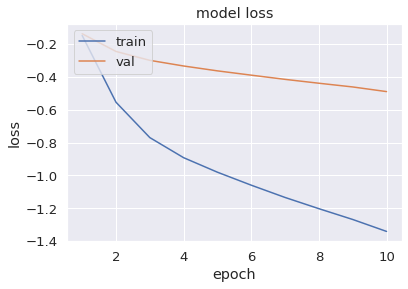

In [45]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

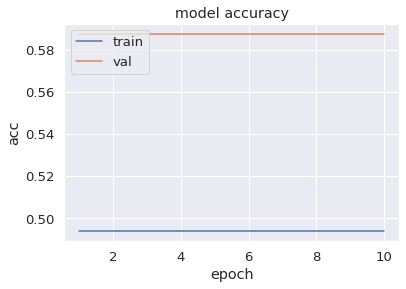

In [47]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'